Chargement de toutes les données du CSV par chunks et les combiner dans une seule liste

In [1]:
import pandas as pd # type: ignore

# Initialiser une liste vide pour stocker toutes les données
all_data = []

# Lire les données par chunks (par exemple, 10 000 lignes à la fois)
chunks = pd.read_csv('en.openfoodfacts.org.products.csv', encoding="UTF-8", sep="\t", on_bad_lines='skip', chunksize=10000, low_memory=False)

# Itérer sur chaque chunk
for chunk in chunks:
    # Convertir chaque chunk en liste de dictionnaires (ou liste de listes, selon tes besoins)
    all_data.extend(chunk.to_dict(orient='records'))  # Utilisation 'records' pour obtenir une liste de dictionnaires

# À ce stade, all_data contient toutes les lignes du CSV dans une seule liste
print(f"Nombre total de lignes : {len(all_data)}")

Nombre total de lignes : 3475166


Exemple d'accès aux données dans la liste

In [2]:
for row in all_data[:5]:  # Parcourir les 5 premières lignes
    print(row['product_name'], row['nutriscore_grade'])  # Exemple d'accès à des colonnes spécifiques

Filet d
Poudre de grillon unknown
Feuchtes Toilettentuch - Kamille unknown
Almond Dark Chocolate e
Bio inulin a


Pour supprimer toutes les lignes qui ne contiennent pas les valeurs 'a', 'b', 'c', 'd', ou 'e' dans la colonne nutriscore_grade

In [3]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'en.openfoodfacts.org.products.csv'
output_file = 'filtered_openfoodfacts.csv'

# Valeurs valides pour 'nutriscore_grade'
valid_grades = ['a', 'b', 'c', 'd', 'e']

# Initialiser le fichier de sortie (on écrase d'éventuelles anciennes versions)
with open(output_file, 'w') as f:
    pass  # Cela permet de s'assurer que le fichier est réinitialisé

# Liste pour stocker les chunks filtrés si tu veux tout concaténer à la fin
all_filtered_chunks = []

# Lire les données par chunks et les filtrer
chunks = pd.read_csv(input_file, encoding="UTF-8", sep="\t", on_bad_lines='skip', chunksize=10000, low_memory=False)

# Parcourir chaque chunk
for i, chunk in enumerate(chunks):
    # Filtrer les lignes avec des grades valides
    filtered_chunk = chunk[chunk['nutriscore_grade'].isin(valid_grades)]
    
    # Ajouter le chunk filtré à la liste pour la concaténation finale
    all_filtered_chunks.append(filtered_chunk)
    
    # Écrire les données filtrées dans un fichier CSV au fur et à mesure
    filtered_chunk.to_csv(output_file, mode='a', header=(i == 0), index=False, sep="\t")

# Concaténer tous les chunks filtrés dans un seul DataFrame (si nécessaire)
df = pd.concat(all_filtered_chunks, ignore_index=True)

print(f"Les lignes non valides ont été supprimées. Les données filtrées sont sauvegardées dans {output_file}.")

Les lignes non valides ont été supprimées. Les données filtrées sont sauvegardées dans filtered_openfoodfacts.csv.


Suppressions des colonnes contenant plus de 70% de valeurs manquants 

In [1]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'filtered_openfoodfacts.csv'
output_file_cleaned = 'cleaned_openfoodfacts.csv'

# Seuil de valeurs manquantes (70%)
missing_threshold = 0.7

# Lire les données filtrées
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Supprimer les colonnes contenant plus de 70 % de valeurs manquantes
df_cleaned = df.loc[:, df.isnull().mean() < missing_threshold]

# Enregistrer les données nettoyées dans un nouveau fichier CSV
df_cleaned.to_csv(output_file_cleaned, index=False, sep="\t")

print(f"Les colonnes avec plus de 70 % de valeurs manquantes ont été supprimées. Les données nettoyées sont sauvegardées dans {output_file_cleaned}.")

Les colonnes avec plus de 70 % de valeurs manquantes ont été supprimées. Les données nettoyées sont sauvegardées dans cleaned_openfoodfacts.csv.


Suppression  des lignes où tous les nutriments sont vides

In [2]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'cleaned_openfoodfacts.csv'
output_file_final = 'final_openfoodfacts.csv'

# Lire les données nettoyées
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Liste des colonnes correspondant aux nutriments 
nutrient_columns = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'
]

# Filtrer les colonnes existantes dans le DataFrame
existing_columns = [col for col in nutrient_columns if col in df.columns]

    # Supprimer les lignes où toutes les colonnes de nutriments existantes sont vides
df_cleaned = df.dropna(how='all', subset=existing_columns)

# Enregistrer les données nettoyées dans un nouveau fichier CSV
df_cleaned.to_csv(output_file_final, index=False, sep="\t")

print(f"Les lignes où tous les nutriments sont vides ont été supprimées. Les données nettoyées sont sauvegardées dans {output_file_final}.")


Les lignes où tous les nutriments sont vides ont été supprimées. Les données nettoyées sont sauvegardées dans final_openfoodfacts.csv.


Suppressions des doublons sur marque et produit 

In [3]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'final_openfoodfacts.csv'
output_file_dedup = 'dedup_openfoodfacts.csv'

# Lire les données nettoyées
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Supprimer les doublons basés sur les colonnes 'brands' et 'product_name'
df_dedup = df.drop_duplicates(subset=['brands', 'product_name'], keep='first')

# Enregistrer les données sans doublons dans un nouveau fichier CSV
df_dedup.to_csv(output_file_dedup, index=False, sep="\t")

print(f"Les doublons sur les colonnes 'brands' et 'product_name' ont été supprimés. Les données sont sauvegardées dans {output_file_dedup}.")

Les doublons sur les colonnes 'brands' et 'product_name' ont été supprimés. Les données sont sauvegardées dans dedup_openfoodfacts.csv.


suppressions des variables redondantes (_tags , _en)

In [1]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'dedup_openfoodfacts.csv'
output_file_cleaned = 'cleaned_final_openfoodfacts.csv'

# Lire les données sans doublons
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Supprimer les colonnes contenant '_tags' ou '_en' dans leur nom
tag_columns_to_drop = [col for col in df.columns if col.endswith('_tags')]

# Colonnes à exclure de la suppression des '_en'
excluded_columns = ['countries_en', 'main_category_en', 'categories_en']

# Filtrer les colonnes qui se terminent par '_en', en excluant certaines colonnes
en_columns_to_drop = [col for col in df.columns if col.endswith('_en') and col not in excluded_columns]

# Supprimer les colonnes sélectionnées
df = df.drop(tag_columns_to_drop, axis=1)
df = df.drop(en_columns_to_drop, axis=1)

# Enregistrer les données nettoyées dans un nouveau fichier CSV
df.to_csv(output_file_cleaned, index=False, sep="\t")

print(f"Les colonnes redondantes avec '_tags' et '_en' ont été supprimées. Les données nettoyées sont sauvegardées dans {output_file_cleaned}.")


Les colonnes redondantes avec '_tags' et '_en' ont été supprimées. Les données nettoyées sont sauvegardées dans cleaned_final_openfoodfacts.csv.


Suppressions de certaines colonnes non pertinentes pour mon analyse

In [3]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'cleaned_final_openfoodfacts.csv'
output_file_final = 'final_openfoodfacts_cleaned.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Liste des colonnes à supprimer
columns_to_drop = [
    'url', 'creator', 'created_t', 'last_modified_t', 'last_modified_datetime', 
    'last_modified_by', 'last_updated_t', 'last_updated_datetime'
]

# Supprimer ces colonnes
df_cleaned = df.drop(columns=columns_to_drop)

# Enregistrer les données nettoyées dans un nouveau fichier CSV
df_cleaned.to_csv(output_file_final, index=False, sep="\t")

print(f"Les colonnes non pertinentes ont été supprimées. Les données finales sont sauvegardées dans {output_file_final}.")

Les colonnes non pertinentes ont été supprimées. Les données finales sont sauvegardées dans final_openfoodfacts_cleaned.csv.


Réalisation d'un graphique en barres des produits par année

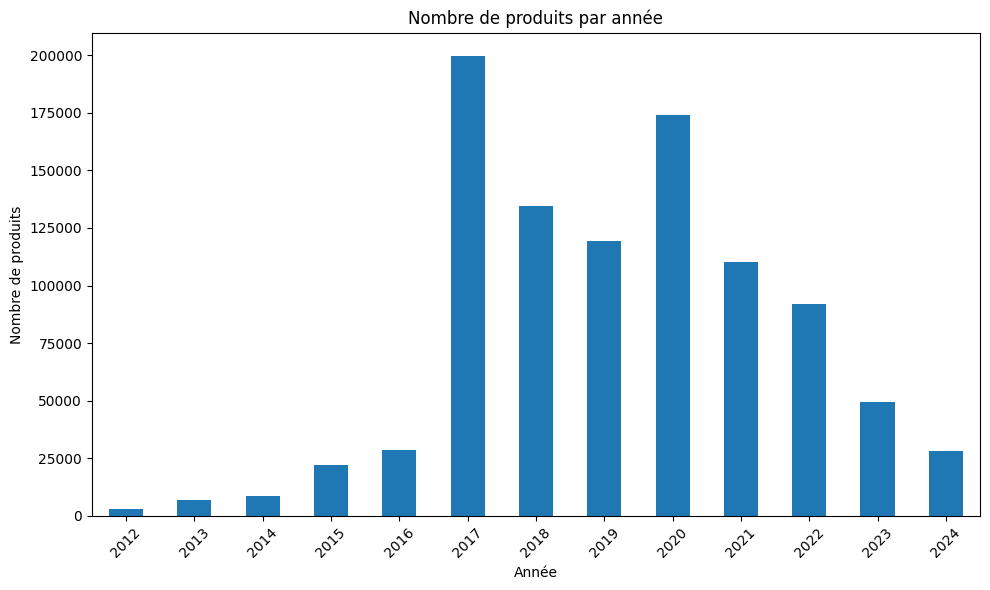

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Fichier CSV nettoyé
input_file = 'final_openfoodfacts_cleaned.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Assurez-vous que la colonne de date est en format datetime (ici 'created_datetime')
df['created_datetime'] = pd.to_datetime(df['created_datetime'], errors='coerce')

# Extraire l'année de création
df['year'] = df['created_datetime'].dt.year

# Supprimer les lignes où la date n'a pas pu être convertie
df = df.dropna(subset=['created_datetime'])

# Compter les produits par année
products_per_year = df['year'].value_counts().sort_index()

# Créer un graphique en barres
plt.figure(figsize=(10,6))
products_per_year.plot(kind='bar')
plt.title('Nombre de produits par année')
plt.xlabel('Année')
plt.ylabel('Nombre de produits')
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

Analyse des pays :

- les pays dans (countries_en) sont à split (ex: Afghanistan,France,Germany)
- stocker les différents pays dans une liste 
- comparer la liste avec une base de données pays 
- supprimer les pays erronnés
- remplir les pays vide par “unknown”

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7284\575534606.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette=palette)


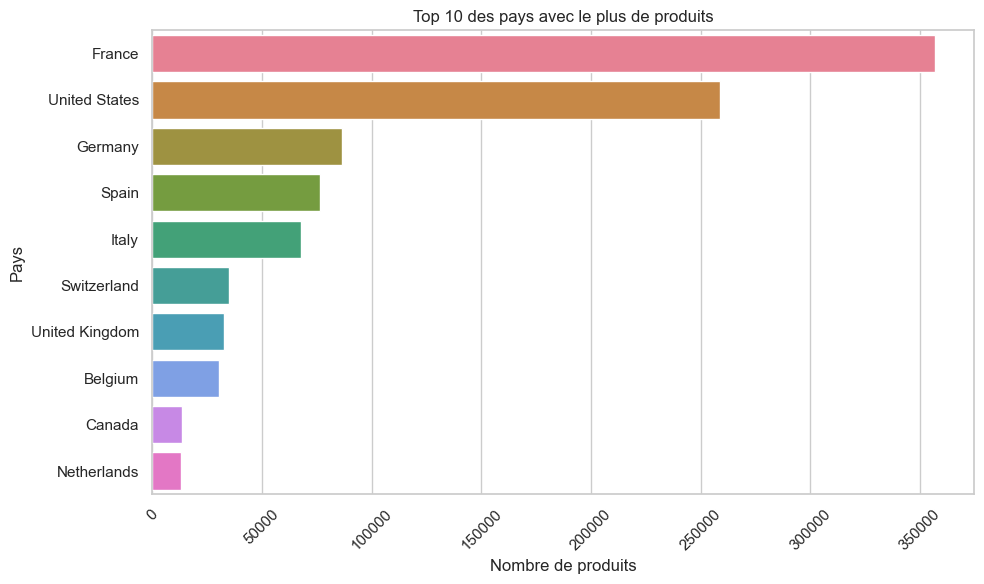

In [7]:
import pandas as pd
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt

# Fichier CSV nettoyé
input_file = 'final_openfoodfacts_cleaned.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Supprimer les lignes où 'countries_en' est vide
df['countries_en'] = df['countries_en'].fillna('unknown')

# Splitter la colonne 'countries' en plusieurs pays (en utilisant la virgule comme séparateur)
df['countries_en'] = df['countries_en'].str.split(',')

# Exploser les listes en lignes (chaque pays devient une ligne)
df_exploded = df.explode('countries_en')

# Supprimer les espaces supplémentaires avant/après les noms des pays
df_exploded['countries_en'] = df_exploded['countries_en'].str.strip()

# Comparer la liste avec une base de données officielle des pays (pycountry)
def is_valid_country(country):
    if country.lower() == 'unknown':
        return True  # Garder "unknown" comme valide
    try:
        pycountry.countries.lookup(country)
        return True
    except LookupError:
        return False

# Appliquer la validation des pays
df_exploded['valid_country'] = df_exploded['countries_en'].apply(is_valid_country)

# Supprimer les pays erronés
df_valid_countries = df_exploded[df_exploded['valid_country'] == True]

# Compter le nombre de produits par pays
country_counts = df_valid_countries['countries_en'].value_counts()

# Visualiser les 10 pays avec le plus de produits
top_countries = country_counts.head(10)

# Générer une palette de couleurs unique pour chaque pays
palette = sns.color_palette("husl", len(top_countries))

# Configuration de Seaborn pour des graphiques plus élégants
sns.set(style="whitegrid")

# Créer un graphique à barres avec une couleur différente pour chaque pays
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette=palette)

plt.title('Top 10 des pays avec le plus de produits')
plt.xlabel('Nombre de produits')
plt.ylabel('Pays')
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

Analyse des catégories :
- categories_en','pnns_groups_1','pnns_groups_2','main_category_en 
- les catégories sont à split
- remplir les catégories vide par “unknown

Ce script permet de voir les 10 premières catégories pour chaque colonne (categories_en, pnns_groups_1, pnns_groups_2, main_category_en) et fait la visualisation pour évaluer leur pertinence. Si certaines catégories ont très peu de données, on pourras décider de les exclure de l'entraînement des modèles.


Analyse de la colonne 'categories_en' :
categories_en
Plant-based foods and beverages      306199
Plant-based foods                    267064
Snacks                               212987
Sweet snacks                         154096
Dairies                              105397
Cereals and potatoes                 105004
Beverages                             84383
Meats and their products              84182
Fermented foods                       81875
Fermented milk products               79190
Meals                                 70509
Desserts                              69654
Fruits and vegetables based foods     68874
Biscuits and cakes                    68425
Cereals and their products            63828
Condiments                            63563
Meats                                 62377
Frozen foods                          57052
Sauces                                54785
Cheeses                               50612
Confectioneries                       50384
Spreads              

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7284\161360837.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


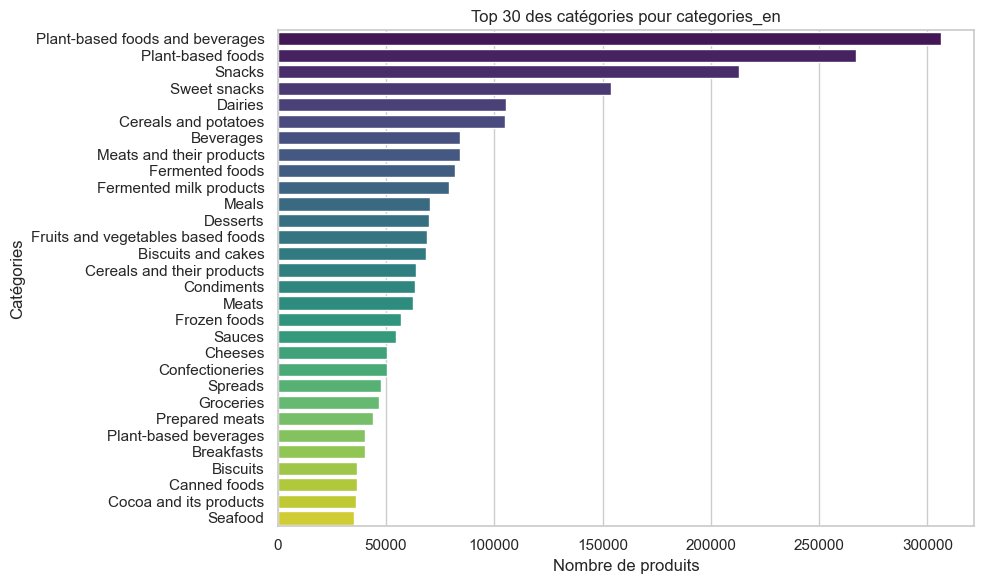


Analyse de la colonne 'pnns_groups_1' :
pnns_groups_1
Sugary snacks              1006405
Cereals and potatoes        765725
Milk and dairy products     695646
Fish Meat Eggs              594746
Fruits and vegetables       445678
Fat and sauces              397039
Beverages                   380990
unknown                     380311
Salty snacks                354232
Composite foods             305956
Alcoholic beverages            315
Name: count, dtype: int64


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7284\161360837.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


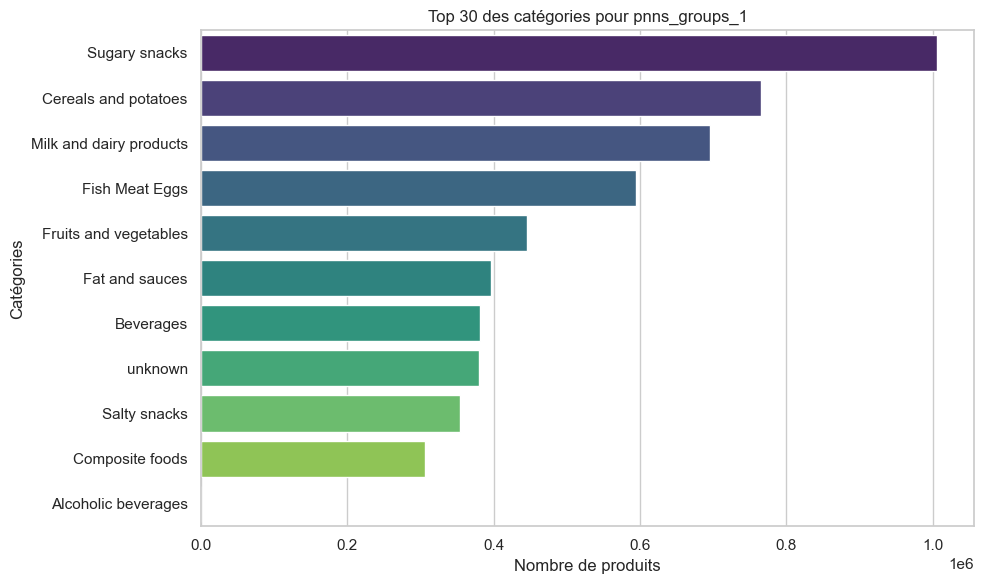


Analyse de la colonne 'pnns_groups_2' :
pnns_groups_2
Sweets                              436158
Biscuits and cakes                  390258
unknown                             380311
Cereals                             346717
Cheese                              291299
Milk and yogurt                     258761
Vegetables                          246597
Dressings and sauces                244006
One-dish meals                      229106
Processed meat                      214191
Fish and seafood                    200911
Bread                               161966
Meat                                158979
Fats                                153033
Salty and fatty products            150105
Appetizers                          133486
Breakfast cereals                   132773
Chocolate products                  130373
Fruits                              107201
Legumes                             102132
Sweetened beverages                  95341
Fruit juices                         86213

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7284\161360837.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


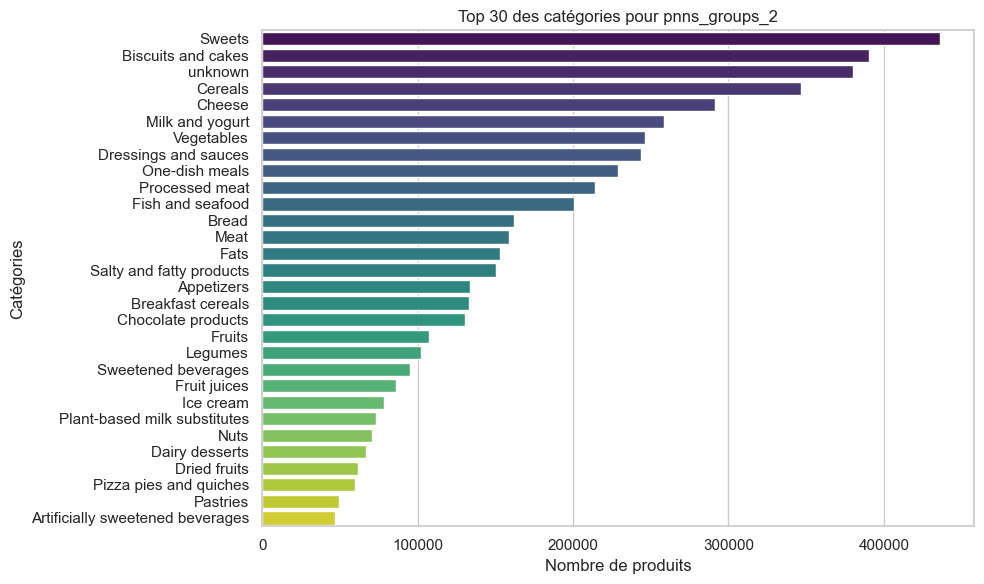


Analyse de la colonne 'main_category_en' :
main_category_en
Groceries                     191060
Biscuits                       70060
Cheeses                        59298
Yogurts                        56556
Virgin olive oils              44258
Confectioneries                41708
Breads                         41578
Sweetened beverages            41010
Cakes                          28753
Pastas                         28308
Chocolate candies              28055
Cereals and their products     27924
Snacks                         27725
Candies                        26995
Dark chocolates                26435
Potato crisps                  24631
Frozen desserts                24317
Peanut butters                 24314
Breakfast cereals              20598
Crackers                       20263
Canned vegetables              19687
Strawberry jams                19487
Salads                         19398
Frozen vegetables              18899
Greek-style yogurts            18019
Hummus        

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7284\161360837.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


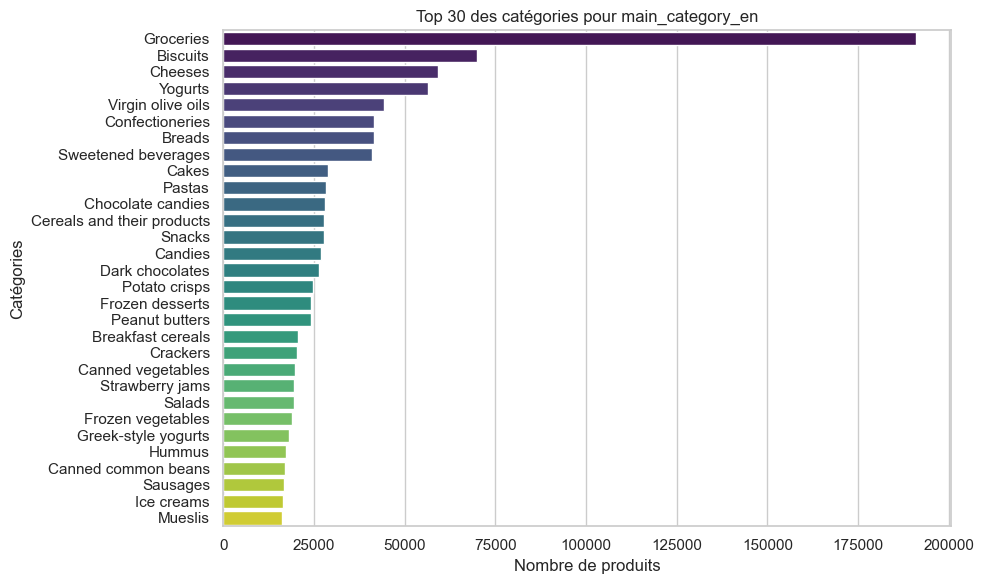

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fichier CSV nettoyé
input_file = 'final_openfoodfacts_cleaned.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Liste des colonnes à analyser
columns_to_analyze = ['categories_en', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']

# Remplir les champs vides par 'unknown'
df[columns_to_analyze] = df[columns_to_analyze].fillna('unknown')

# Splitter les catégories (s'il y a des listes de valeurs séparées par une virgule)
for col in columns_to_analyze:
    df[col] = df[col].str.split(',')

# Exploser les listes en lignes individuelles
for col in columns_to_analyze:
    df = df.explode(col)

# Supprimer les espaces autour des valeurs
for col in columns_to_analyze:
    df[col] = df[col].str.strip()

# Analyser la pertinence de chaque colonne en comptant les occurrences
for col in columns_to_analyze:
    print(f"\nAnalyse de la colonne '{col}' :")
    print(df[col].value_counts().head(30))  # Afficher les 10 premières catégories

    # Visualiser les 10 premières catégories sous forme de graphique
    top_categories = df[col].value_counts().head(30)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
    plt.title(f'Top 30 des catégories pour {col}')
    plt.xlabel('Nombre de produits')
    plt.ylabel('Catégories')
    plt.tight_layout()
    plt.show()

Extraction des données contenant que les nutriments _100g

In [9]:
import pandas as pd

# Fichier CSV d'entrée et de sortie
input_file = 'final_openfoodfacts_cleaned.csv'
output_file = 'nutrients_100g_only.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)

# Extraire les colonnes se terminant par '_100g'
nutrient_columns = [col for col in df.columns if col.endswith('_100g')]
nutrient_data = df[nutrient_columns]

# Enregistrer les données des nutriments dans un nouveau fichier CSV
nutrient_data.to_csv(output_file, index=False, sep="\t")

print(f"Les données des nutriments _100g ont été extraites et sauvegardées dans {output_file}.")

Les données des nutriments _100g ont été extraites et sauvegardées dans nutrients_100g_only.csv.


Analyse des nutriments _100g

In [10]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
import seaborn as sns

# Fichier CSV nettoyé (utilisé pour l'analyse)
input_file = 'nutrients_100g_only.csv'

# Lire les données
df = pd.read_csv(input_file, sep="\t", encoding="UTF-8", low_memory=False)
df.head(10)


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,406.0000,1700.0,6.600000,4.300000,6.70000,6.70000,NaN,80.000000,0.500000,0.200000,0.013317,12.0
1,578.0000,2401.0,40.900000,21.500000,40.70000,35.00000,8.400000,7.500000,0.000000,0.000000,12.000000,19.0
2,208.0000,840.0,0.000000,0.000000,8.00000,8.00000,88.000000,0.000000,0.230000,0.092000,50.000000,-2.0
3,85.0000,356.0,2.400000,1.100000,9.60000,2.20000,1.300000,5.700000,1.181102,0.472441,0.000000,17.0
4,536.0715,2243.0,35.714284,8.928572,46.42857,28.57143,10.714286,10.714286,0.089286,0.035714,NaN,15.0
5,442.0000,1852.0,22.000000,2.600000,54.00000,25.00000,1.400000,6.400000,0.530000,0.212000,22.666667,13.0
6,217.0000,908.0,13.000000,6.700000,15.00000,3.60000,NaN,8.800000,0.800000,0.320000,8.200000,11.0
7,460.0000,1926.0,24.000000,6.000000,54.00000,31.00000,1.400000,6.400000,0.480000,0.192000,16.250000,17.0
8,467.0000,1953.0,25.000000,6.100000,53.00000,29.00000,2.500000,6.300000,0.450000,0.180000,16.250000,16.0
9,458.0000,1917.0,24.000000,6.000000,53.00000,29.00000,0.000000,6.300000,0.450000,0.180000,16.250000,17.0


Informations sur les différentes catégories

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975699 entries, 0 to 975698
Data columns (total 12 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   energy-kcal_100g                                       941147 non-null  float64
 1   energy_100g                                            974875 non-null  float64
 2   fat_100g                                               974821 non-null  float64
 3   saturated-fat_100g                                     952865 non-null  float64
 4   carbohydrates_100g                                     974367 non-null  float64
 5   sugars_100g                                            967781 non-null  float64
 6   fiber_100g                                             541263 non-null  float64
 7   proteins_100g                                          974808 non-null  float64
 8   salt_100g                         

La description

In [12]:
df.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,9.411470e+05,9.748750e+05,974821.000000,952865.000000,974367.000000,967781.000000,541263.000000,974808.000000,9.753370e+05,9.753370e+05,644643.000000,975699.000000
mean,1.062533e+11,1.025773e+11,15.337360,5.666055,28.266607,13.319934,3.116261,8.529568,8.202294e+07,3.280918e+07,19.132751,8.825377
std,1.030793e+14,1.012804e+14,847.784922,386.898072,28.836559,282.454029,16.223502,79.611244,8.100515e+10,3.240206e+10,35.909717,8.815679
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-1.000000,-1.000000,-8.330000,0.000000e+00,0.000000e+00,-65.887256,-15.000000
25%,1.071429e+02,4.480000e+02,1.000000,0.100000,4.000000,0.800000,0.000000,1.600000,8.000000e-02,3.200000e-02,0.000000,1.000000
50%,2.620000e+02,1.088000e+03,7.500000,2.000000,16.000000,3.750000,1.700000,6.000000,5.350000e-01,2.140000e-01,0.703125,9.000000
75%,4.000000e+02,1.674000e+03,21.800000,7.300000,53.000000,18.000000,3.800000,12.000000,1.300000e+00,5.200000e-01,23.689996,15.000000
max,1.000000e+17,1.000000e+17,678454.000000,377372.000000,4903.000000,277223.000000,9888.000000,77667.000000,8.000000e+13,3.200000e+13,13461.000000,40.000000


Vérification des valeurs manquantes

Valeurs manquantes par colonne :
energy-kcal_100g                                          34552
energy_100g                                                 824
fat_100g                                                    878
saturated-fat_100g                                        22834
carbohydrates_100g                                         1332
sugars_100g                                                7918
fiber_100g                                               434436
proteins_100g                                               891
salt_100g                                                   362
sodium_100g                                                 362
fruits-vegetables-nuts-estimate-from-ingredients_100g    331056
nutrition-score-fr_100g                                       0
dtype: int64
energy-kcal_100g                                          3.541256
energy_100g                                               0.084452
fat_100g                                            

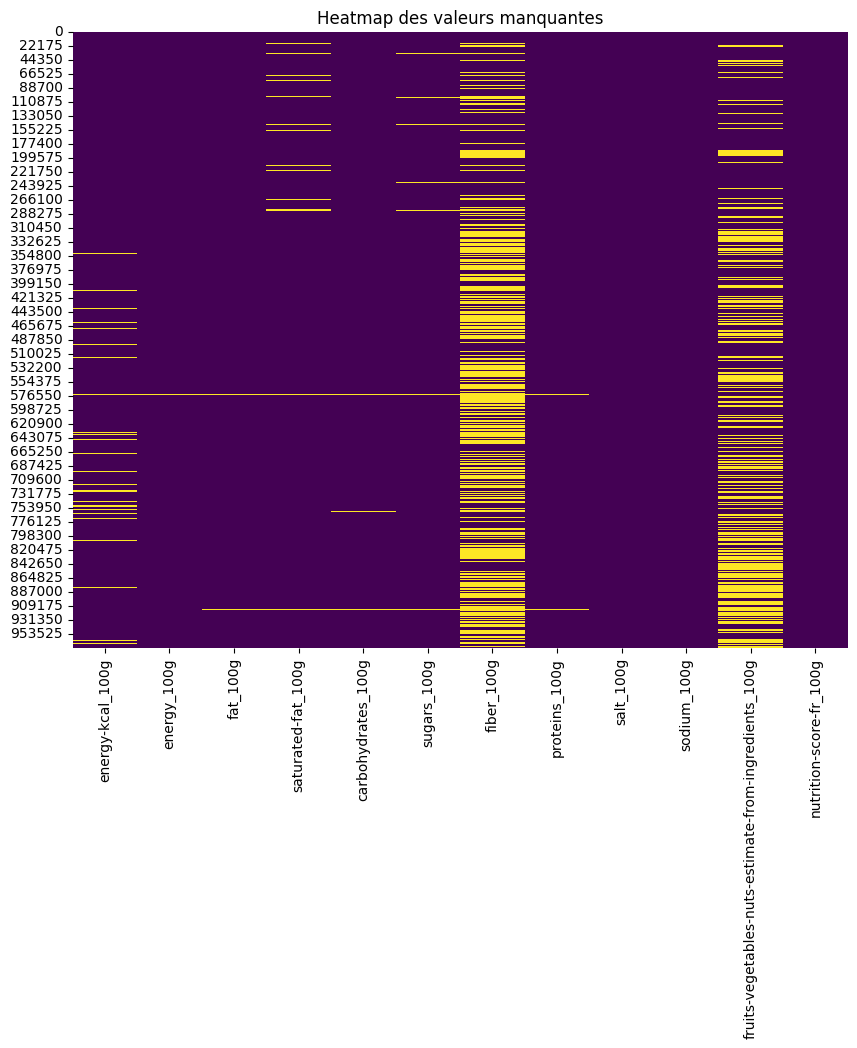

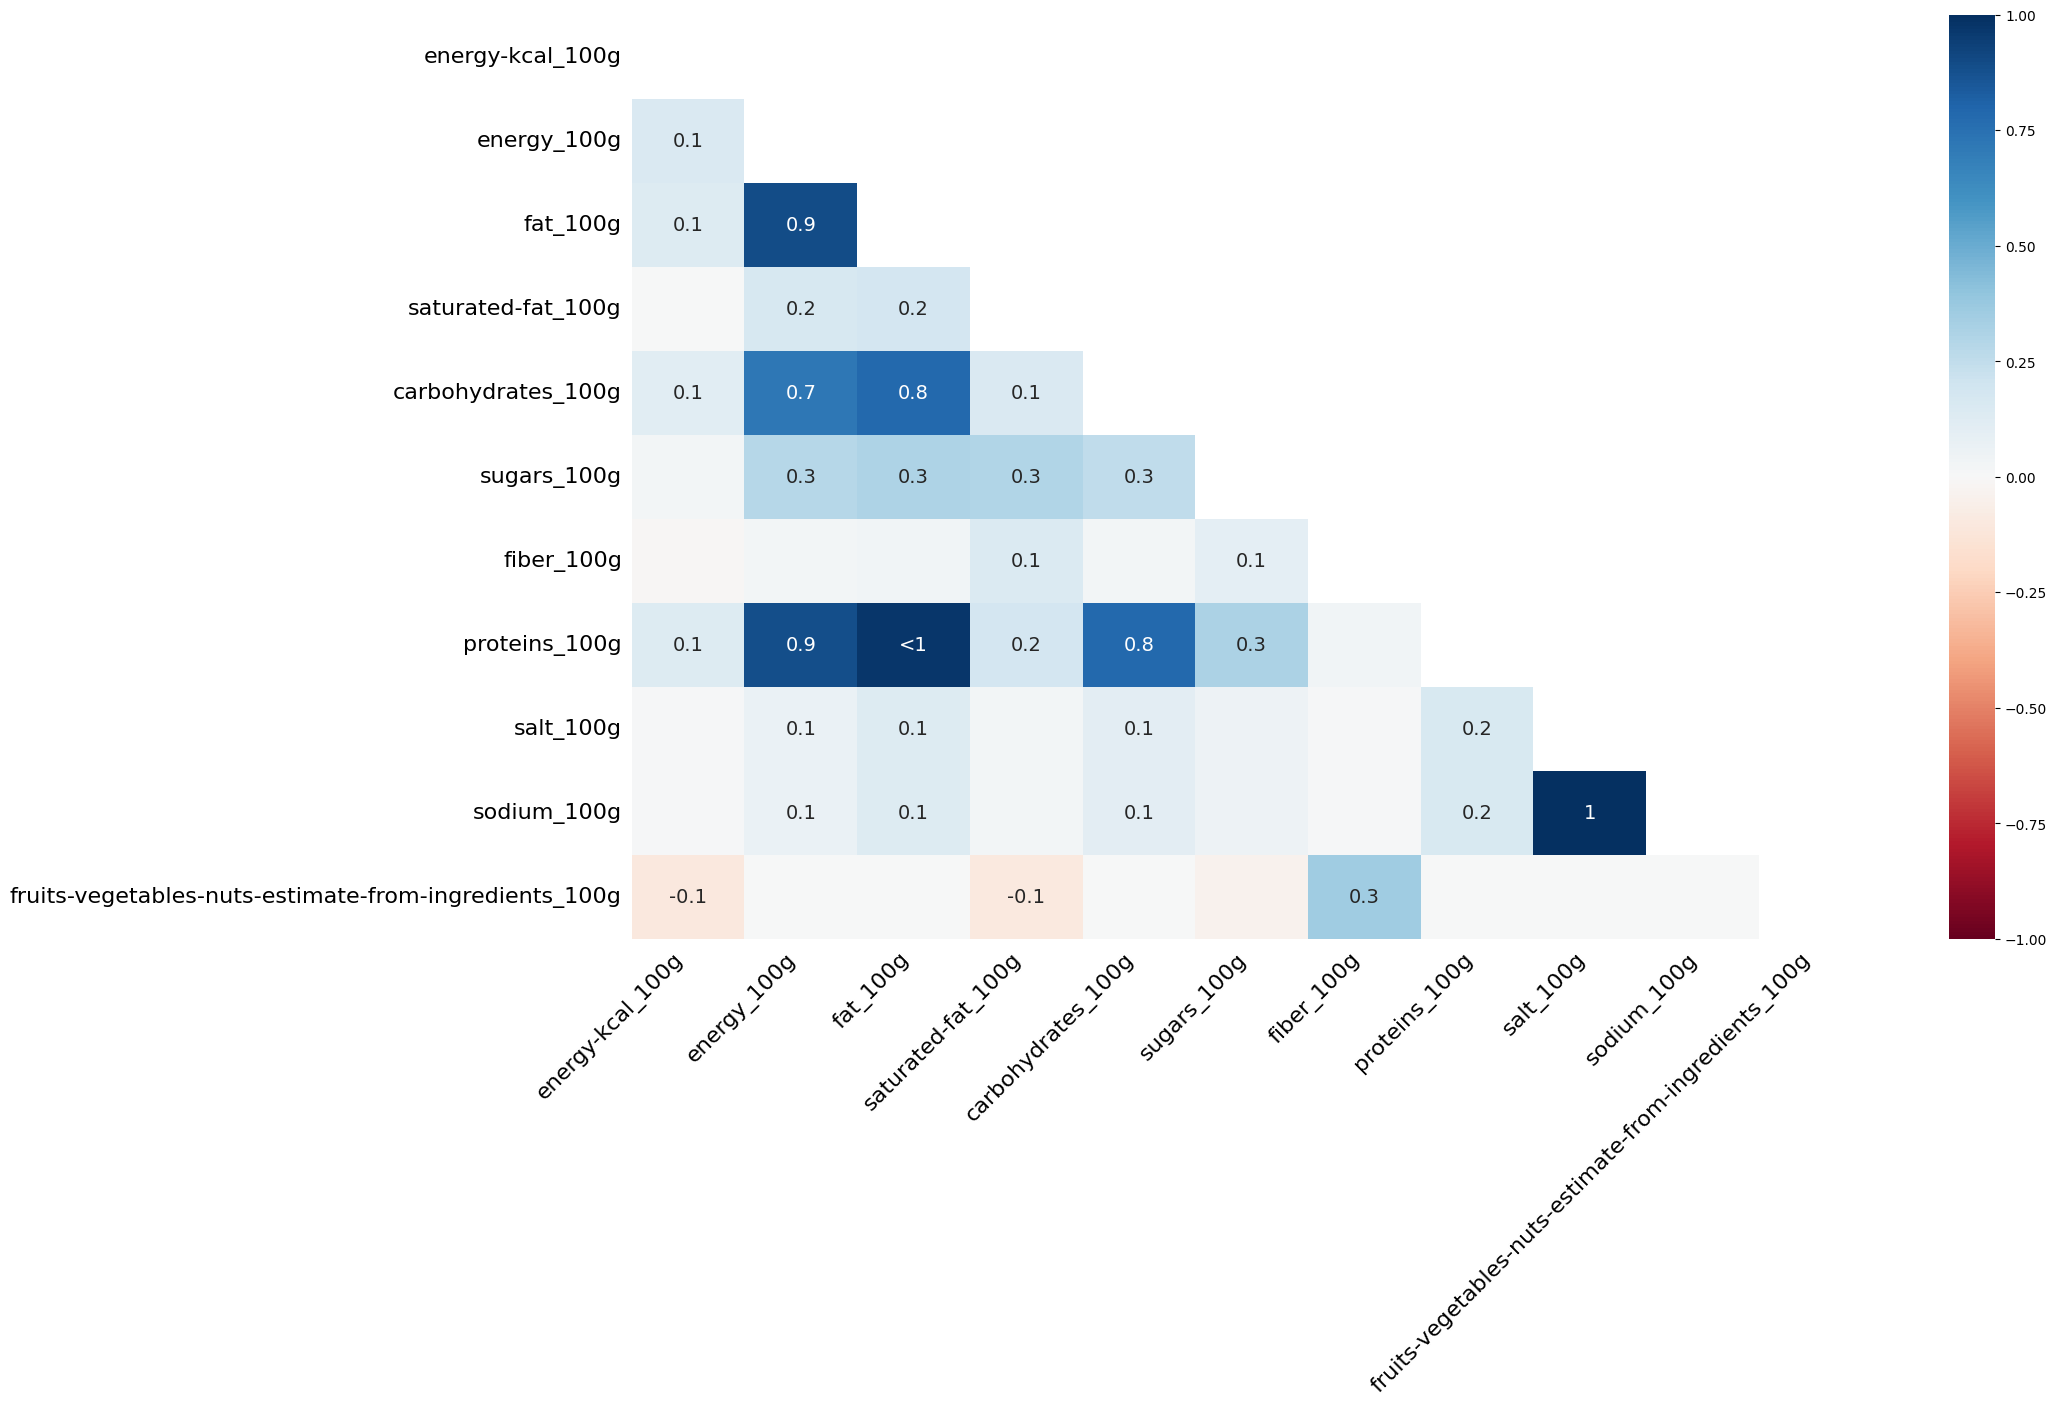

In [25]:
# Vérification initiale des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(nutrient_data.isnull().sum())

# Analyser les valeurs manquantes par colonne en pourcentage
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
print(missing_values_percentage)

# Afficher les valeurs manquantes en pourcentage pour chaque colonne
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values (%)': missing_values_percentage})
missing_values_df_sorted = missing_values_df.sort_values(by='Missing Values (%)', ascending=False)

# Heatmap des valeurs manquantes
plt.figure(figsize=(10, 8))
sns.heatmap(nutrient_data.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap des valeurs manquantes")
plt.show()

# Analyser la corrélation entre les valeurs manquantes
msno.heatmap(df)
plt.show()

Détection des valeurs abérrantes

In [13]:
# Définir les limites par défaut pour les nutriments (0 à 100g)
default_lower_limit = 0
default_upper_limit = 100

# Détection des valeurs aberrantes (pour les nutriments)
aberrant_values = {}

# Liste des colonnes nutritionnelles (en pourcentage des 100g) à vérifier
nutrition_columns_100g = [col for col in df.columns if col.endswith('_100g') and 'energy' not in col]

# Détection des valeurs aberrantes pour les nutriments standards (hors énergie)
for col in nutrition_columns_100g:
    # Vérifier les valeurs inférieures à 0 ou supérieures à 100
    aberrant = df[col][(df[col] < default_lower_limit) | (df[col] > default_upper_limit)]
    if not aberrant.empty:
        aberrant_values[col] = aberrant

# Détection des valeurs aberrantes spécifiques pour l'énergie
energy_aberrant_values = {}

# Limites globales pour l'énergie
kcal_limit = (0, 900)  # Limite pour les kcal (0 à 900 kcal pour 100g)
kj_limit = (0, 3760)   # Limite pour les kJ (0 à 3760 kJ pour 100g)

# Fonction pour vérifier les valeurs aberrantes de l'énergie
def detect_energy_aberrations(row):
    kcal_value = row['energy-kcal_100g']
    kj_value = row['energy_100g']
    
    # Vérifier les valeurs pour kcal
    if not (kcal_limit[0] <= kcal_value <= kcal_limit[1]):
        energy_aberrant_values.setdefault('energy-kcal_100g', []).append(kcal_value)
    
    # Vérifier les valeurs pour kJ
    if not (kj_limit[0] <= kj_value <= kj_limit[1]):
        energy_aberrant_values.setdefault('energy_100g', []).append(kj_value)

# Appliquer la détection des valeurs aberrantes pour l'énergie
df.apply(detect_energy_aberrations, axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
975694    None
975695    None
975696    None
975697    None
975698    None
Length: 975699, dtype: object

Nettoyage des données aberrantes

In [15]:
import pandas as pd
import numpy as np

# Charger le fichier contenant les données
file_path = 'nutrients_100g_only.csv'  
df = pd.read_csv(file_path, sep='\t')

# Définir les limites pour chaque colonne
# Limites globales pour les nutriments (0 à 100g)
default_lower_limit = 0
default_upper_limit = 100

# Limites globales pour l'énergie
kcal_limit = (0, 900)  # Limite pour les kcal (0 à 900 kcal pour 100g)
kj_limit = (0, 3760)   # Limite pour les kJ (0 à 3760 kJ pour 100g)

# Liste des colonnes nutritionnelles (en pourcentage des 100g) à vérifier
nutrition_columns_100g = [col for col in df.columns if col.endswith('_100g') and 'energy' not in col]

# Suppression des lignes avec des valeurs aberrantes pour les nutriments
for col in nutrition_columns_100g:
    df = df[(df[col] >= default_lower_limit) & (df[col] <= default_upper_limit)]

# Suppression des lignes avec des valeurs aberrantes pour l'énergie
df = df[(df['energy-kcal_100g'] >= kcal_limit[0]) & (df['energy-kcal_100g'] <= kcal_limit[1])]
df = df[(df['energy_100g'] >= kj_limit[0]) & (df['energy_100g'] <= kj_limit[1])]

# Sauvegarder les données après suppression des valeurs aberrantes
df.to_csv('data_without_outliers.csv', sep='\t', index=False)
print("Lignes avec des valeurs aberrantes supprimées. Fichier sauvegardé sous 'data_without_outliers.csv'.")


Lignes avec des valeurs aberrantes supprimées. Fichier sauvegardé sous 'data_without_outliers.csv'.


Imputation des Valeurs Manquantes par la Médiane 

In [16]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Charger le fichier avec les lignes contenant des valeurs aberrantes supprimées
file_path = 'data_without_outliers.csv'  # Fichier résultant de la suppression des valeurs aberrantes
df = pd.read_csv(file_path, sep='\t')

# Imputation des valeurs manquantes avec la médiane
median_imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(median_imputer.fit_transform(df), columns=df.columns)

# Sauvegarder les données après imputation des valeurs manquantes
df_imputed.to_csv('imputed_median_values.csv', sep='\t', index=False)
print("Valeurs manquantes imputées avec la médiane. Fichier sauvegardé sous 'imputed_median_values.csv'.")

Valeurs manquantes imputées avec la médiane. Fichier sauvegardé sous 'imputed_median_values.csv'.


Vérification des données nettoyées

In [18]:
# Vérifier s'il reste des valeurs manquantes après l'imputation
missing_values_after_imputation = df_imputed.isnull().sum()
print("\nValeurs manquantes après imputation :")
print(missing_values_after_imputation)


Valeurs manquantes après imputation :
energy-kcal_100g                                         0
energy_100g                                              0
fat_100g                                                 0
saturated-fat_100g                                       0
carbohydrates_100g                                       0
sugars_100g                                              0
fiber_100g                                               0
proteins_100g                                            0
salt_100g                                                0
sodium_100g                                              0
fruits-vegetables-nuts-estimate-from-ingredients_100g    0
nutrition-score-fr_100g                                  0
dtype: int64


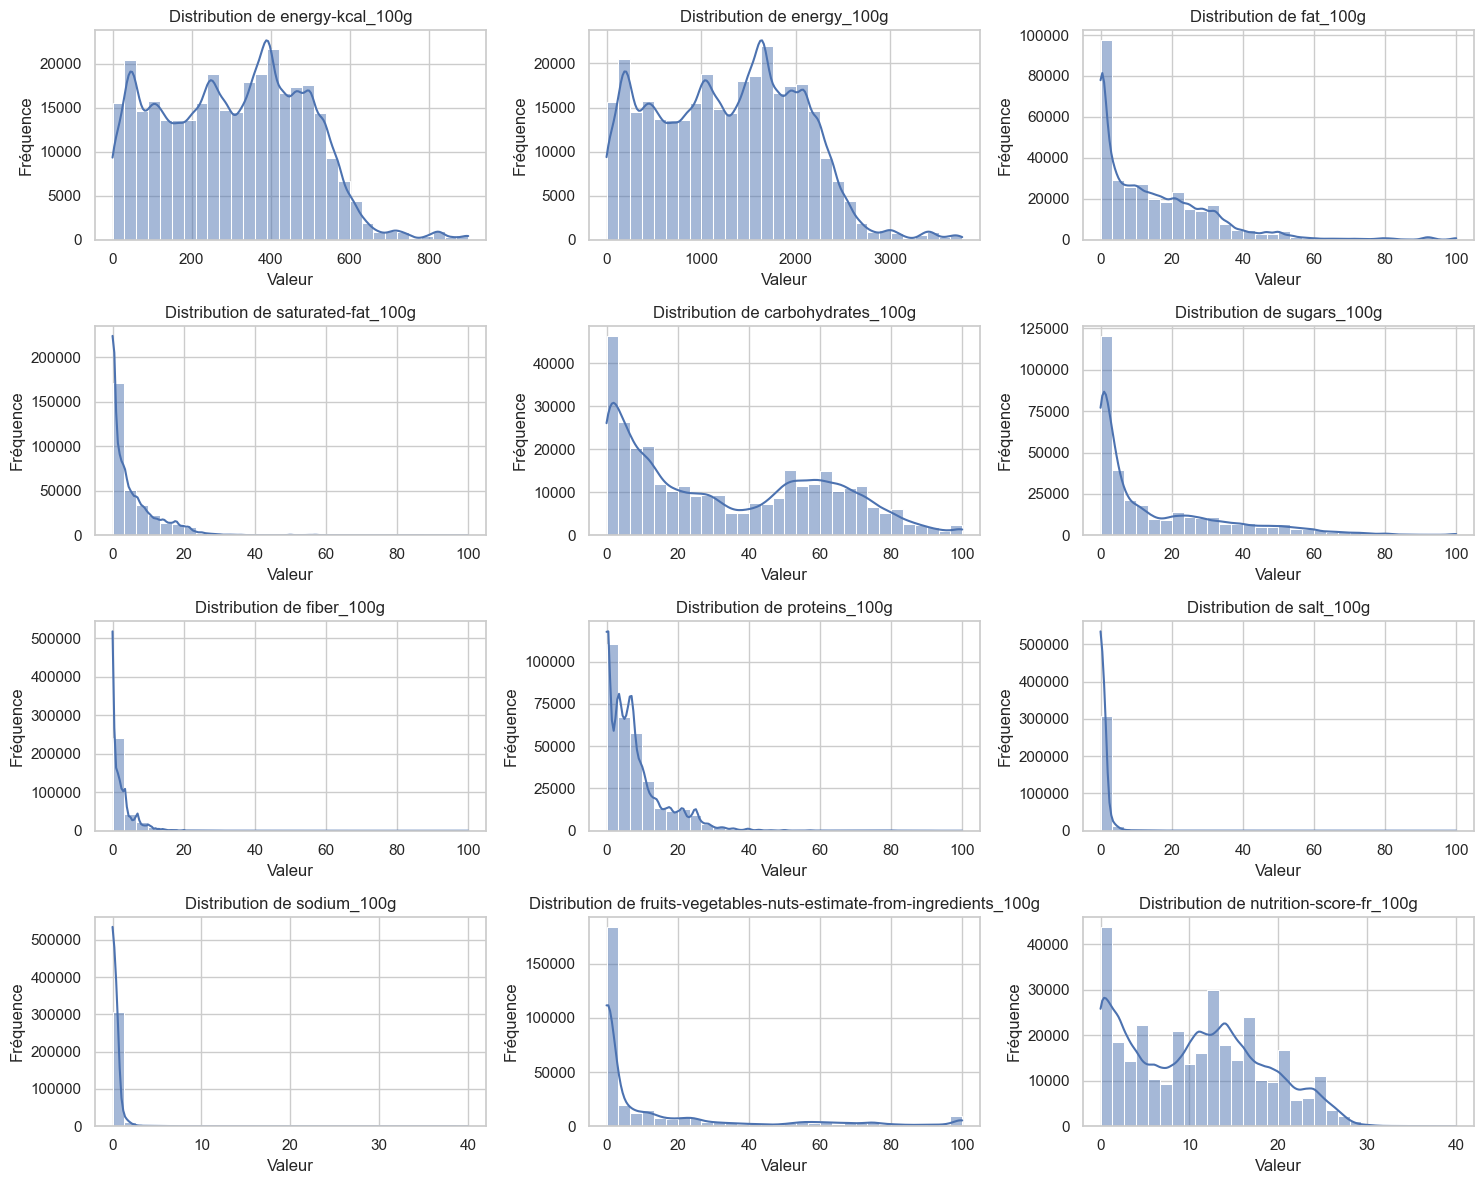

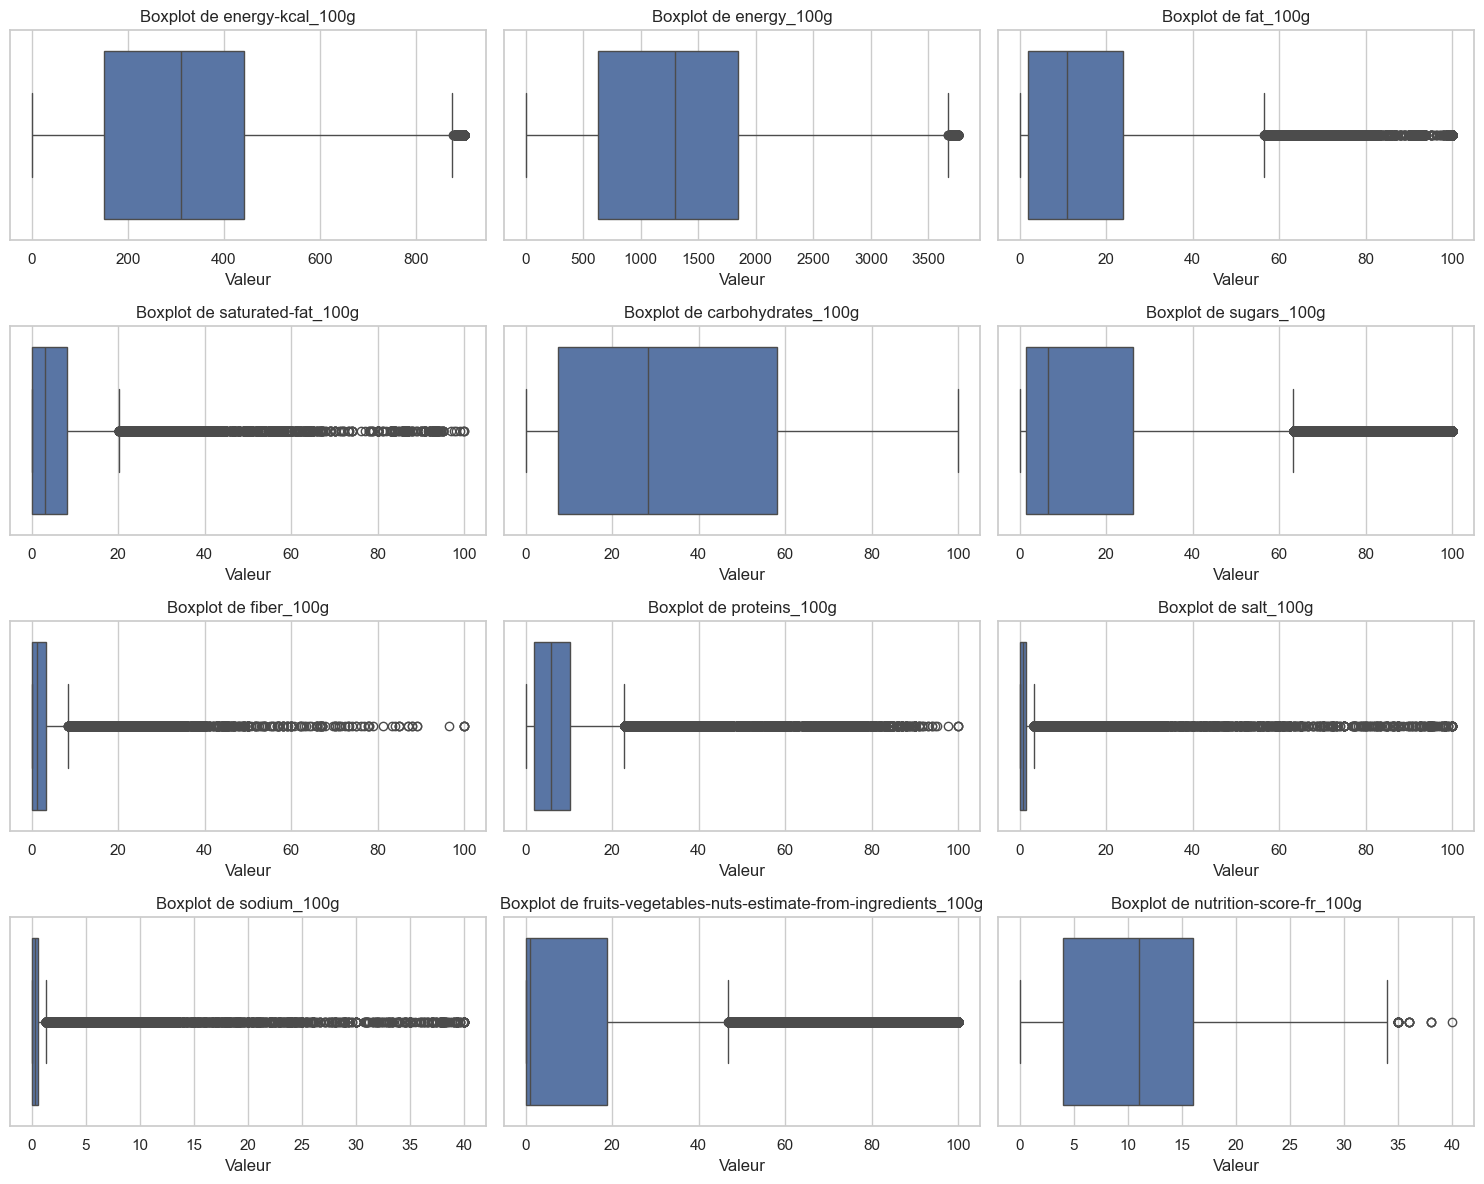

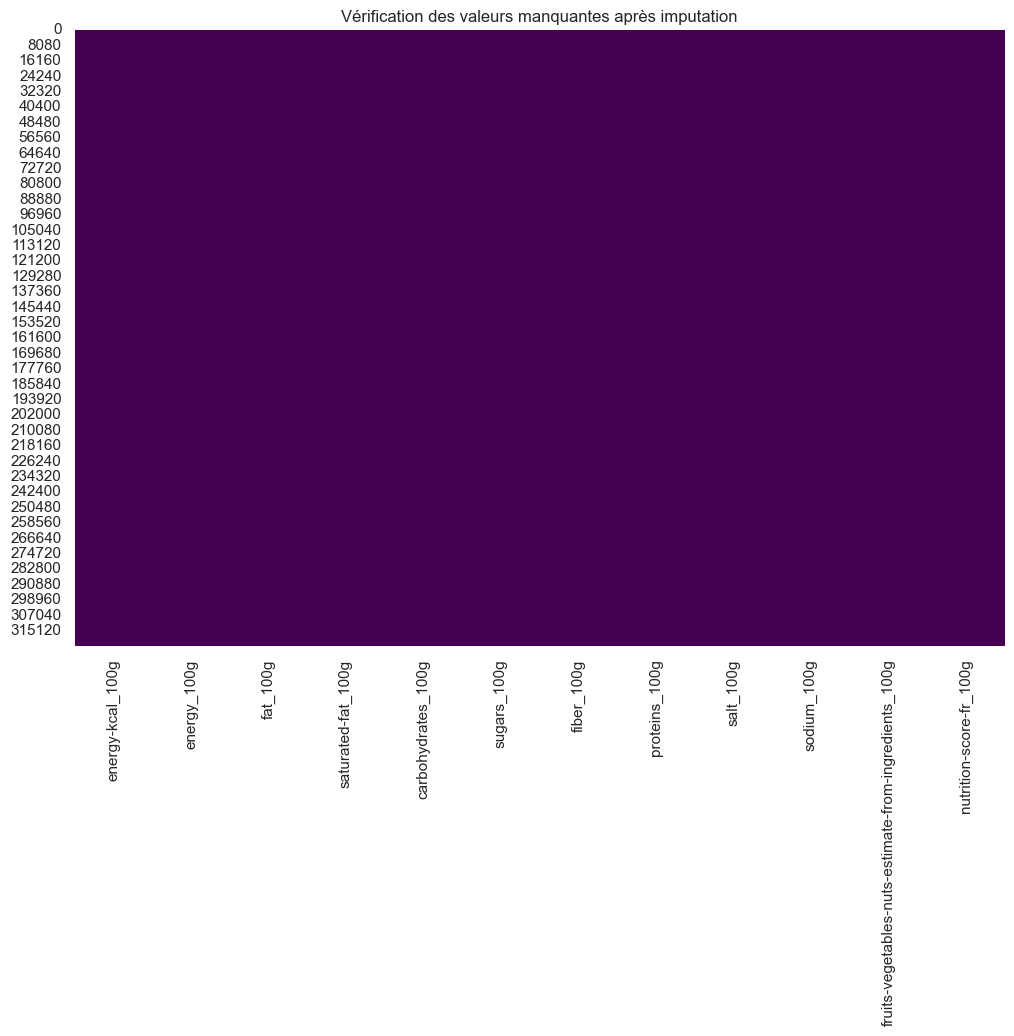

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier nettoyé avec les valeurs manquantes imputées
file_path = 'imputed_median_values.csv'  # Fichier résultant de l'imputation
df_imputed = pd.read_csv(file_path, sep='\t')

# Configuration de Seaborn pour des graphiques plus élégants
sns.set(style="whitegrid")

# 1. Histogrammes de la distribution des valeurs après imputation
plt.figure(figsize=(15, 12))
for i, col in enumerate(df_imputed.columns, start=1):
    plt.subplot(4, 3, i)
    sns.histplot(df_imputed[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Valeur')
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

# 2. Boxplots pour visualiser les valeurs extrêmes
plt.figure(figsize=(15, 12))
for i, col in enumerate(df_imputed.columns, start=1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_imputed[col].dropna())
    plt.title(f'Boxplot de {col}')
    plt.xlabel('Valeur')

plt.tight_layout()
plt.show()

# 3. Heatmap pour vérifier les valeurs manquantes
plt.figure(figsize=(12, 8))
sns.heatmap(df_imputed.isnull(), cbar=False, cmap="viridis")
plt.title('Vérification des valeurs manquantes après imputation')
plt.show()

In [21]:
print(df.columns)

Index(['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')
